In [1]:
import os
import json

import numpy as np
import pandas as pd
import math

from tqdm import trange, tqdm

import pingouin

import matplotlib.pyplot as plt

In [2]:
# load trial and gaze data
trialdata = pd.read_csv('trialdata_to73_RT.csv')
fixdata = pd.read_csv('fixdata_to73_RT.csv')
# demo = pd.read_csv('DV_Digit_Search/Output/dti-search-digits-exp-fall-log.csv')

# only using experimental data
fixdata = fixdata[(fixdata.block=='exp') & (fixdata.within_block=='exp') ]
trialdata = trialdata[(trialdata.block=='exp') & (trialdata.within_block=='exp')]

/tmp/ipykernel_38298/247432582.py:3: DtypeWarning: Columns (9,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  fixdata = pd.read_csv('fixdata_to73_RT.csv')


In [3]:


# original ACC set timeout case as True
# Define a function to apply the conditions
def add_acc(row):
    if row['RT_EVENT_BUTTON_ID'] == '6' and row['target_present'] == 'FALSE':
        return True
    elif row['RT_EVENT_BUTTON_ID'] == '7' and row['target_present'] == 'TRUE':
        return True
    else:
        return False

# Apply the function to create a new column 'NewColumn'
# trialdata.target_present = trialdata.target_present.astype(bool)
trialdata['ACC'] = trialdata.apply(add_acc, axis=1)


# preprocess fixdata

# of subject data:  59
average acc 0.9600343895848685


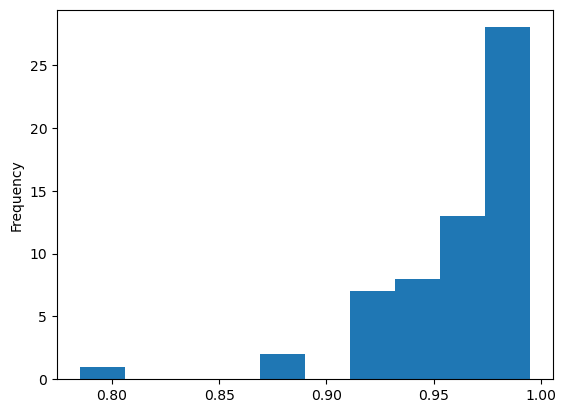

In [4]:
# load subject acc information from trial data
subjlist = np.unique(trialdata.RECORDING_SESSION_LABEL.tolist())
print("# of subject data: ", len(subjlist))

subjacc = trialdata.groupby('RECORDING_SESSION_LABEL')['ACC'].mean().reset_index() 
subjacc.ACC.plot(kind='hist')
print('average acc', subjacc.ACC.mean())

# of subject data:  59
average acc 0.9591342189647275


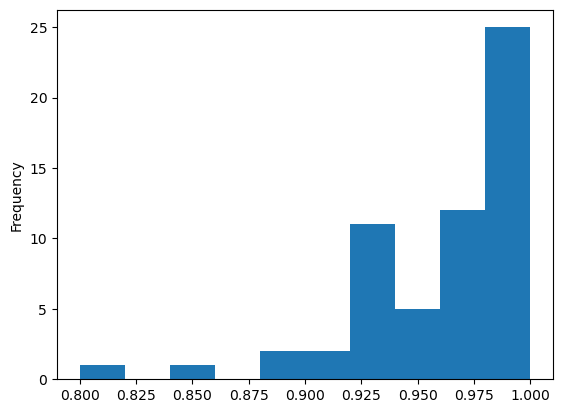

In [5]:
# TP accuracy
subjlist = np.unique(trialdata.RECORDING_SESSION_LABEL.tolist())
print("# of subject data: ", len(subjlist))

trialdata_present = trialdata[trialdata.target_present=='TRUE']
subjacc = trialdata_present.groupby('RECORDING_SESSION_LABEL')['ACC'].mean().reset_index() 
subjacc.ACC.plot(kind='hist')
print('average acc', subjacc.ACC.mean())

# of subject data:  59
average acc 0.9609957627118644


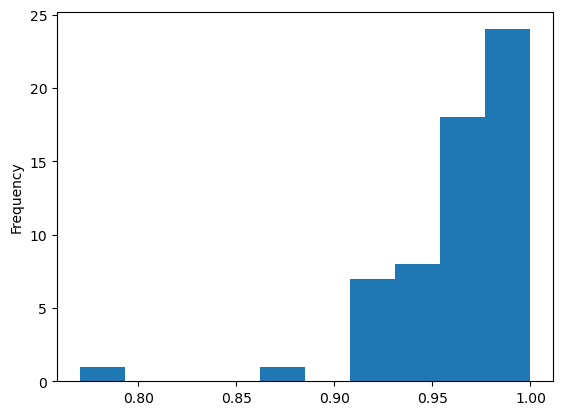

In [6]:
# TA accuracy
# subjlist = np.unique(trialdata.RECORDING_SESSION_LABEL.tolist())
print("# of subject data: ", len(subjlist))

trialdata_absent = trialdata[trialdata.target_present=='FALSE']
subjacc = trialdata_absent.groupby('RECORDING_SESSION_LABEL')['ACC'].mean().reset_index() 
subjacc.ACC.plot(kind='hist')
print('average acc', subjacc.ACC.mean())

In [7]:
# subject info and get valid data
subj_valid = []
subj_invalid = []

for subj in subjlist:
    subj_fdf = fixdata[fixdata.RECORDING_SESSION_LABEL== subj].copy()
    subj_tdf = trialdata[trialdata.RECORDING_SESSION_LABEL== subj].copy()
    n_trial = subj_tdf.INDEX.nunique() 
    acc =subj_tdf.ACC.mean()
    
    # check first all trials are there and check acc
    if n_trial >= 200: #224: 50 exp and 6prac #56*4 and acc > 0.9: 
        subj_valid.append(subj)
    else:
        subj_invalid.append(subj)
    
        
print(f'valid subject # {len(subj_valid)}, invalid subject # {len(subj_invalid)} ')
# trialdata[trialdata.RECORDING_SESSION_LABEL== 'DSP068']['INDEX'].nunique()

vfixdata = fixdata[fixdata.RECORDING_SESSION_LABEL.isin(subj_valid)].copy()


valid subject # 55, invalid subject # 4 


In [8]:
# change dtype of fix data
vfixdata.replace('.', np.NaN, inplace=True)
vfixdata.dtypes

# find rows with NaN values
# nan_rows = vfixdata[vfixdata.isnull().any(axis=1)]
# nan_rows[cols].isnull().any()
# assert nan_rows[cols].isnull().any().all() == False # check any missing data other than in previous fix columns

RECORDING_SESSION_LABEL     object
TRIAL_INDEX                  int64
CURRENT_FIX_INDEX            int64
CURRENT_FIX_START            int64
CURRENT_FIX_X              float64
CURRENT_FIX_Y              float64
CURRENT_FIX_DURATION         int64
PREVIOUS_SAC_AMPLITUDE      object
PREVIOUS_SAC_ANGLE          object
ACC                         object
RT                          object
Session_Name_               object
block                       object
display_index               object
filename                    object
target                      object
target_present              object
within_block                object
dtype: object

In [9]:
trialdata.replace('.', np.NaN, inplace=True)
trialdata.AVERAGE_FIXATION_DURATION = trialdata.AVERAGE_FIXATION_DURATION.astype(float)
trialdata.SD_FIXATION_DURATION = trialdata.SD_FIXATION_DURATION.astype(float)
trialdata.AVERAGE_SACCADE_AMPLITUDE = trialdata.AVERAGE_SACCADE_AMPLITUDE.astype(float)
trialdata.SD_SACCADE_AMPLITUDE = trialdata.SD_SACCADE_AMPLITUDE.astype(float)
trialdata.SD_SACCADE_AMPLITUDE = trialdata.SD_SACCADE_AMPLITUDE.astype(float)
trialdata.REACTION_TIME = trialdata.REACTION_TIME.astype(float)
trialdata.dtypes

RECORDING_SESSION_LABEL       object
INDEX                          int64
AVERAGE_FIXATION_DURATION    float64
SD_FIXATION_DURATION         float64
AVERAGE_SACCADE_AMPLITUDE    float64
SD_SACCADE_AMPLITUDE         float64
DURATION                       int64
FIXATION_COUNT                 int64
REACTION_TIME                float64
RT_EVENT_BUTTON_ID            object
ACC                             bool
NTRIAL                        object
RT                            object
block                         object
filename                      object
display_index                 object
within_block                  object
target                        object
target_present                object
dtype: object

In [10]:
# fixation filtering based on screen size (1680×1050)
# include only rows where value in column B is between 0 and 1280
cond1 = (vfixdata['CURRENT_FIX_X'] >= 0) & (vfixdata['CURRENT_FIX_X'] <= 1680)
cond2 = (vfixdata['CURRENT_FIX_Y'] >= 0) & (vfixdata['CURRENT_FIX_Y'] <= 1050)
vfixdata_remove = vfixdata[~(cond1 & cond2)]
vfixdata_include = vfixdata[cond1 & cond2]
print(len(vfixdata), 'include #', len(vfixdata_include), 'remove #',len(vfixdata_remove))

vfixdata = vfixdata_include

44510 include # 44475 remove # 35


In [11]:
# get demographic info #TODO
from collections import Counter


demo[["Gender"]] =demo[["Gender"]].apply(lambda s:s.str.replace('"', ""))
valid_sessions = np.unique(vfixdata.RECORDING_SESSION_LABEL.tolist())
correct_filenames = demo['Filename'].tolist()

cantfindlist= []
genderlist = []
agelist = []

for session in valid_sessions:
    filename = (session).upper()+'.edf'
    
    if filename in correct_filenames: 
        genderlist.append(demo[demo['Filename']==filename]['Gender'].item())
        agelist.append(demo[demo['Filename']==filename]['Age'].item())
    else:
        print('cant find: ', session)
        cantfindlist.append(session)

# # manual correction if needed
# renamelist = {'gro12151': 'rgo12151',
#               'rgo11256': 'rgo12256', 
#               'rgo2111': 'rgo21111',
#               'rgo32262': 'rgo32263',
# }


# vfixdata.replace(renamelist, inplace=True)
print(f'average age {np.mean(agelist)}, min {min(agelist)}, max {max(agelist)}')
print('gender:')
item_counts = Counter(genderlist)
for item, count in item_counts.items():
    print(f"{item}: {count}")
    

NameError: name 'demo' is not defined

# create fixation data in dictionary format

In [12]:

subjlist = vfixdata.RECORDING_SESSION_LABEL.unique().tolist()
fdictlist = []

for subj in subjlist:
    
    # load subject data
    sub_trialdata = trialdata.loc[trialdata['RECORDING_SESSION_LABEL']==subj]    
    sub_fixdata = vfixdata.loc[vfixdata['RECORDING_SESSION_LABEL']==subj]


    triallist = sub_trialdata['INDEX'].unique().tolist()
    triallist_wfix = sub_fixdata['TRIAL_INDEX'].unique().tolist() # note some trial doesn't have fixations (when button press is very fast; check the default filtering criterion for Data Viewer)
    
    n_trial_nofix = len(triallist) - len(triallist_wfix)
    print('subject: ', subj, '# of no fixation trials: ', n_trial_nofix)
    # load trial data
    for trial in triallist_wfix:
        
        sub_trial_fixdata = sub_fixdata.loc[sub_fixdata['TRIAL_INDEX']==trial]
        sub_trial_trialdata = sub_trialdata.loc[sub_trialdata['INDEX']==trial]
        
        fdict = {}
        fdict['SUBJECT_ID'] = subj.upper()
        fdict['TRIAL_ID'] = trial
        fdict['CONDITION'] = sub_trial_trialdata['filename'].item().split('_')[-3] # prac_TA_insect_d1871.png
        fdict['IMAGE_ID'] = int(sub_trial_trialdata['filename'].item().split('_')[-1].split('.')[0][1:]) # display idx
        fdict['TARGET'] = sub_trial_trialdata['target'].item()
        fdict['TARGET_PRESENT'] = True if sub_trial_trialdata['target_present'].item()=='TRUE' else False

        buttonid = sub_trial_trialdata['RT_EVENT_BUTTON_ID'].item()
#         if math.isnan(buttonid):
        if isinstance(buttonid, str):
            fdict['BUTTON_ID'] = int(buttonid)
        else: 
            fdict['BUTTON_ID'] = 'timeout'
        
        fdict['ACC'] = sub_trial_trialdata['ACC'].item()
        

        # add fixation data
        fixxs, fixys, fixstarts, fixdurs, sacamps, sacangs = [],[],[],[],[],[]
        for i, dur in enumerate(sub_trial_fixdata['CURRENT_FIX_DURATION'].tolist()):
            fixxs.append(sub_trial_fixdata['CURRENT_FIX_X'].tolist()[i])
            fixys.append(sub_trial_fixdata['CURRENT_FIX_Y'].tolist()[i])
            fixstarts.append(sub_trial_fixdata['CURRENT_FIX_START'].tolist()[i])
            fixdurs.append(sub_trial_fixdata['CURRENT_FIX_DURATION'].tolist()[i])
            sacamps.append(sub_trial_fixdata['PREVIOUS_SAC_AMPLITUDE'].tolist()[i])
            sacangs.append(sub_trial_fixdata['PREVIOUS_SAC_ANGLE'].tolist()[i])

        fdict['FIX_X'] =  fixxs
        fdict['FIX_Y'] = fixys
        fdict['FIX_START'] = fixstarts
        fdict['FIX_DURATION'] = fixdurs
        
        # add average trial data
        fdict['AVERAGE_FIXATION_DURATION'] = sub_trial_trialdata['AVERAGE_FIXATION_DURATION'].item()
        fdict['SD_FIXATION_DURATION'] = sub_trial_trialdata['SD_FIXATION_DURATION'].item()
        fdict['AVERAGE_SACCADE_AMPLITUDE'] = sub_trial_trialdata['AVERAGE_SACCADE_AMPLITUDE'].item()
        fdict['SD_SACCADE_AMPLITUDE'] = sub_trial_trialdata['SD_SACCADE_AMPLITUDE'].item()
        fdict['REACTION_TIME'] = sub_trial_trialdata['REACTION_TIME'].item()

        # add this trial to dataset
        fdictlist.append(fdict)
        
print('# of data: ', len(fdictlist))

subject:  ST024 # of no fixation trials:  0
subject:  ST015 # of no fixation trials:  0
subject:  ST012 # of no fixation trials:  0
subject:  ST041 # of no fixation trials:  0
subject:  ST070 # of no fixation trials:  0
subject:  ST013 # of no fixation trials:  0
subject:  ST014 # of no fixation trials:  0
subject:  ST022 # of no fixation trials:  0
subject:  ST025 # of no fixation trials:  0
subject:  ST071 # of no fixation trials:  0
subject:  st049 # of no fixation trials:  0
subject:  ST040 # of no fixation trials:  0
subject:  ST047 # of no fixation trials:  0
subject:  ST065 # of no fixation trials:  0
subject:  ST062 # of no fixation trials:  0
subject:  ST054 # of no fixation trials:  0
subject:  ST053 # of no fixation trials:  0
subject:  ST007 # of no fixation trials:  0
subject:  ST038 # of no fixation trials:  0
subject:  ST036 # of no fixation trials:  0
subject:  ST009 # of no fixation trials:  0
subject:  ST031 # of no fixation trials:  0
subject:  ST055 # of no fixation

In [43]:
# save data
import json
with open('search-gaze.json', 'w') as f:
    json.dump(fdictlist, f)

# add ROI information

In [4]:
import json
import pickle
import os

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
from matplotlib.patches import Rectangle


In [5]:
with open('search-gaze.json') as f:
    fdictlist = json.load(f)

display_info = np.load('../exp-source/display_info.npy', allow_pickle=True)

In [14]:
fdictlist[0]

{'SUBJECT_ID': 'ST024',
 'TRIAL_ID': 17,
 'CONDITION': 'TP',
 'IMAGE_ID': 1032,
 'TARGET': 'insect',
 'TARGET_PRESENT': True,
 'BUTTON_ID': 7,
 'ACC': True,
 'FIX_X': [827.8, 1099.6, 660.1],
 'FIX_Y': [503.7, 405.2, 208.0],
 'FIX_START': [0, 187, 397],
 'FIX_DURATION': [125, 132, 287],
 'AVERAGE_FIXATION_DURATION': 181.33,
 'SD_FIXATION_DURATION': 91.58,
 'AVERAGE_SACCADE_AMPLITUDE': 12.27,
 'SD_SACCADE_AMPLITUDE': 4.25,
 'REACTION_TIME': 684.0}

In [15]:
display_info[0]

{'display_idx': 0,
 'display_filename': 'TP_cat_d0',
 'condition': 'TP',
 'target_label': 'cat',
 'target_index': 1,
 'clean_objlist': ['../data/imagenet_val_segmented_resized/nontarget/n04330267_ILSVRC2012_val_00023064.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04597913_ILSVRC2012_val_00032112.JPEG',
  '../data/imagenet_val_segmented_resized/cat/n02123045_ILSVRC2012_val_00005358.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n07753113_ILSVRC2012_val_00011675.JPEG'],
 'foveated_objlist': ['../data/imagenet_val_segmented_resized_foveated/nontarget/TP_cat_d0-b0-n04330267_ILSVRC2012_val_00023064.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_cat_d0-b1-n04597913_ILSVRC2012_val_00032112.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/cat/TP_cat_d0-b2-n02123045_ILSVRC2012_val_00005358.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_cat_d0-b3-n07753113_ILSVRC2012_val_00011675.JPEG'],
 'target_idx_in_objlist'

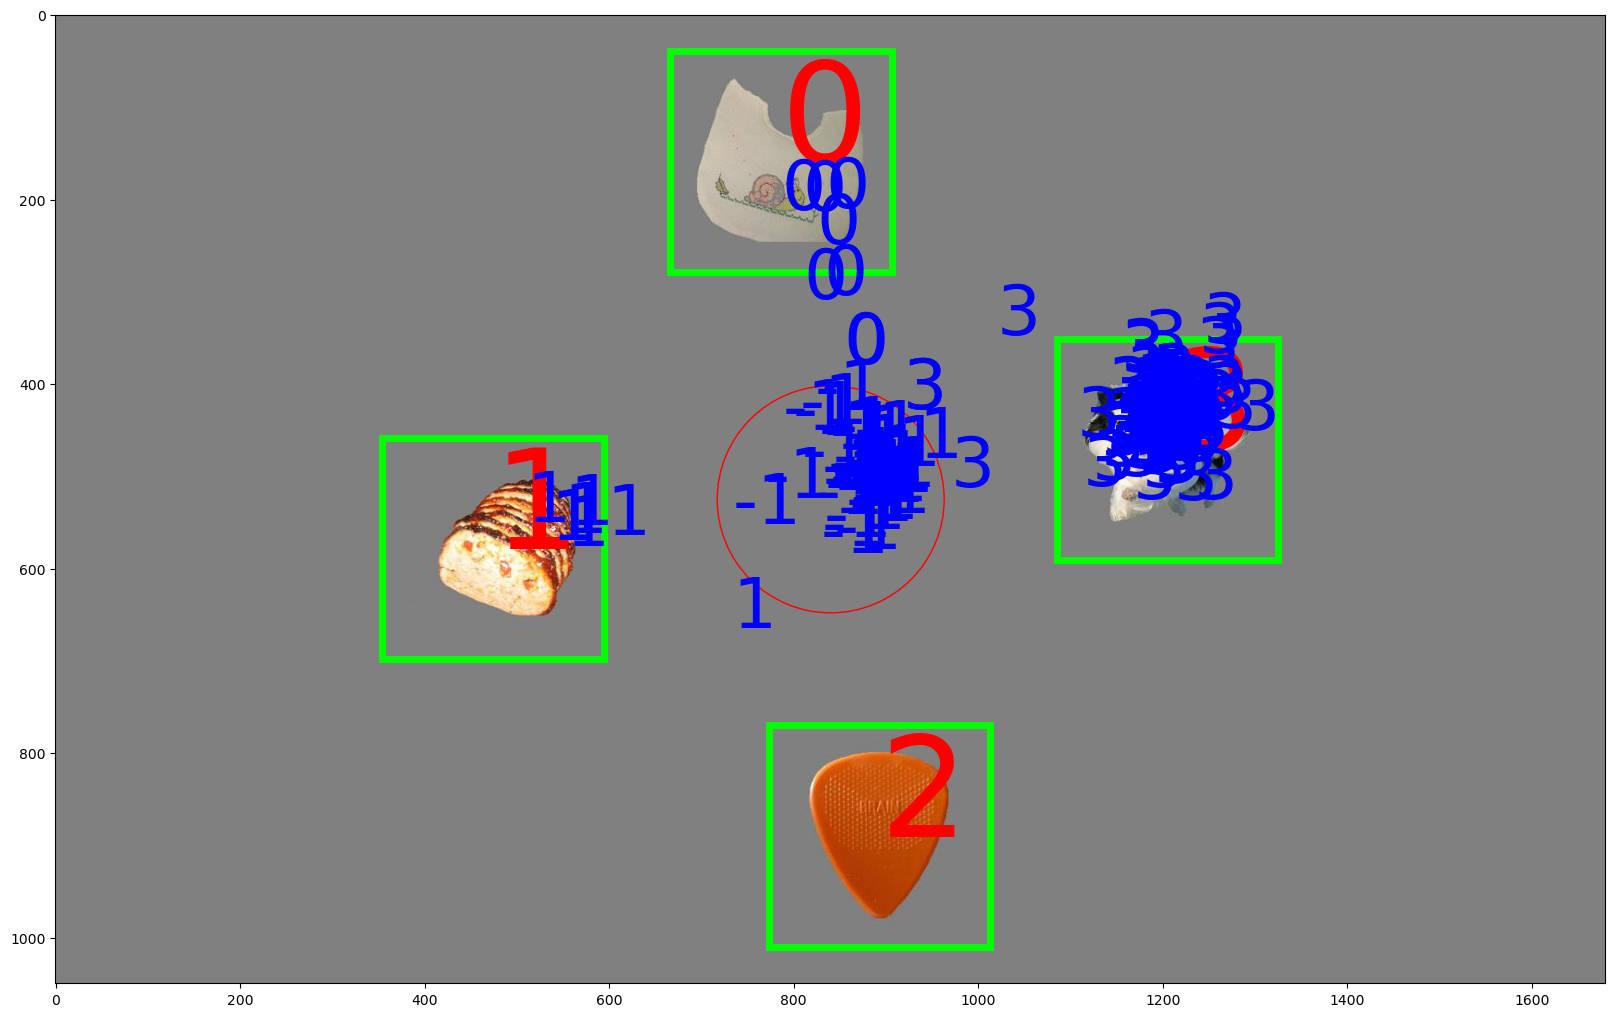

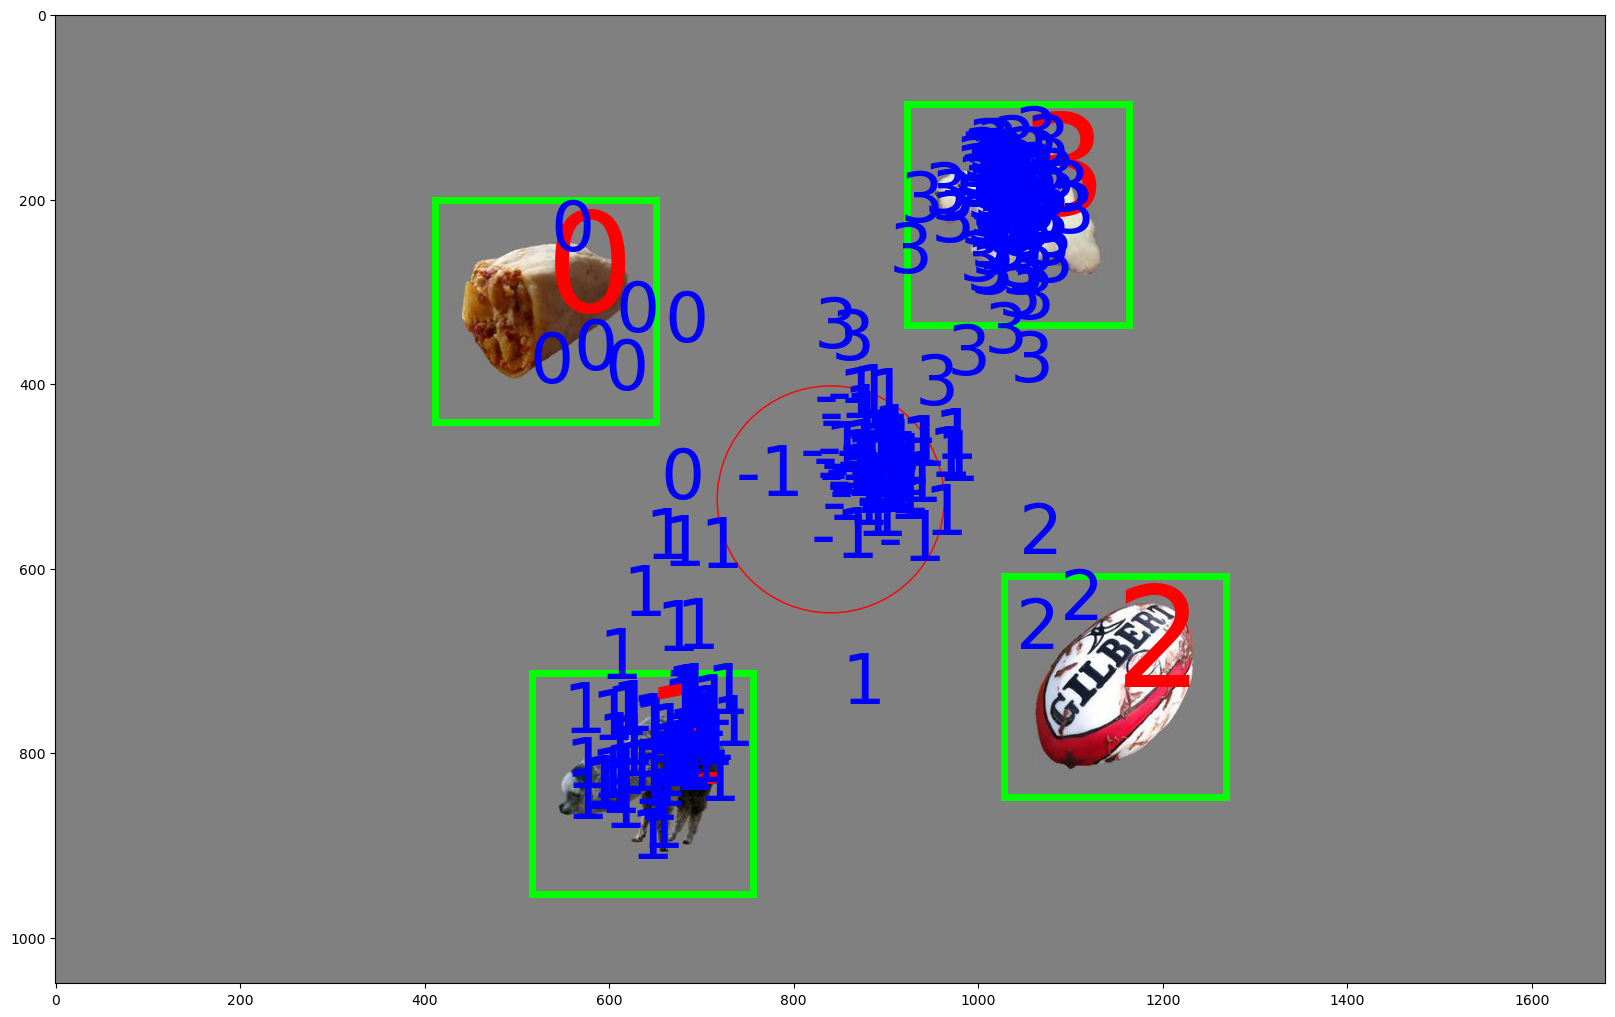

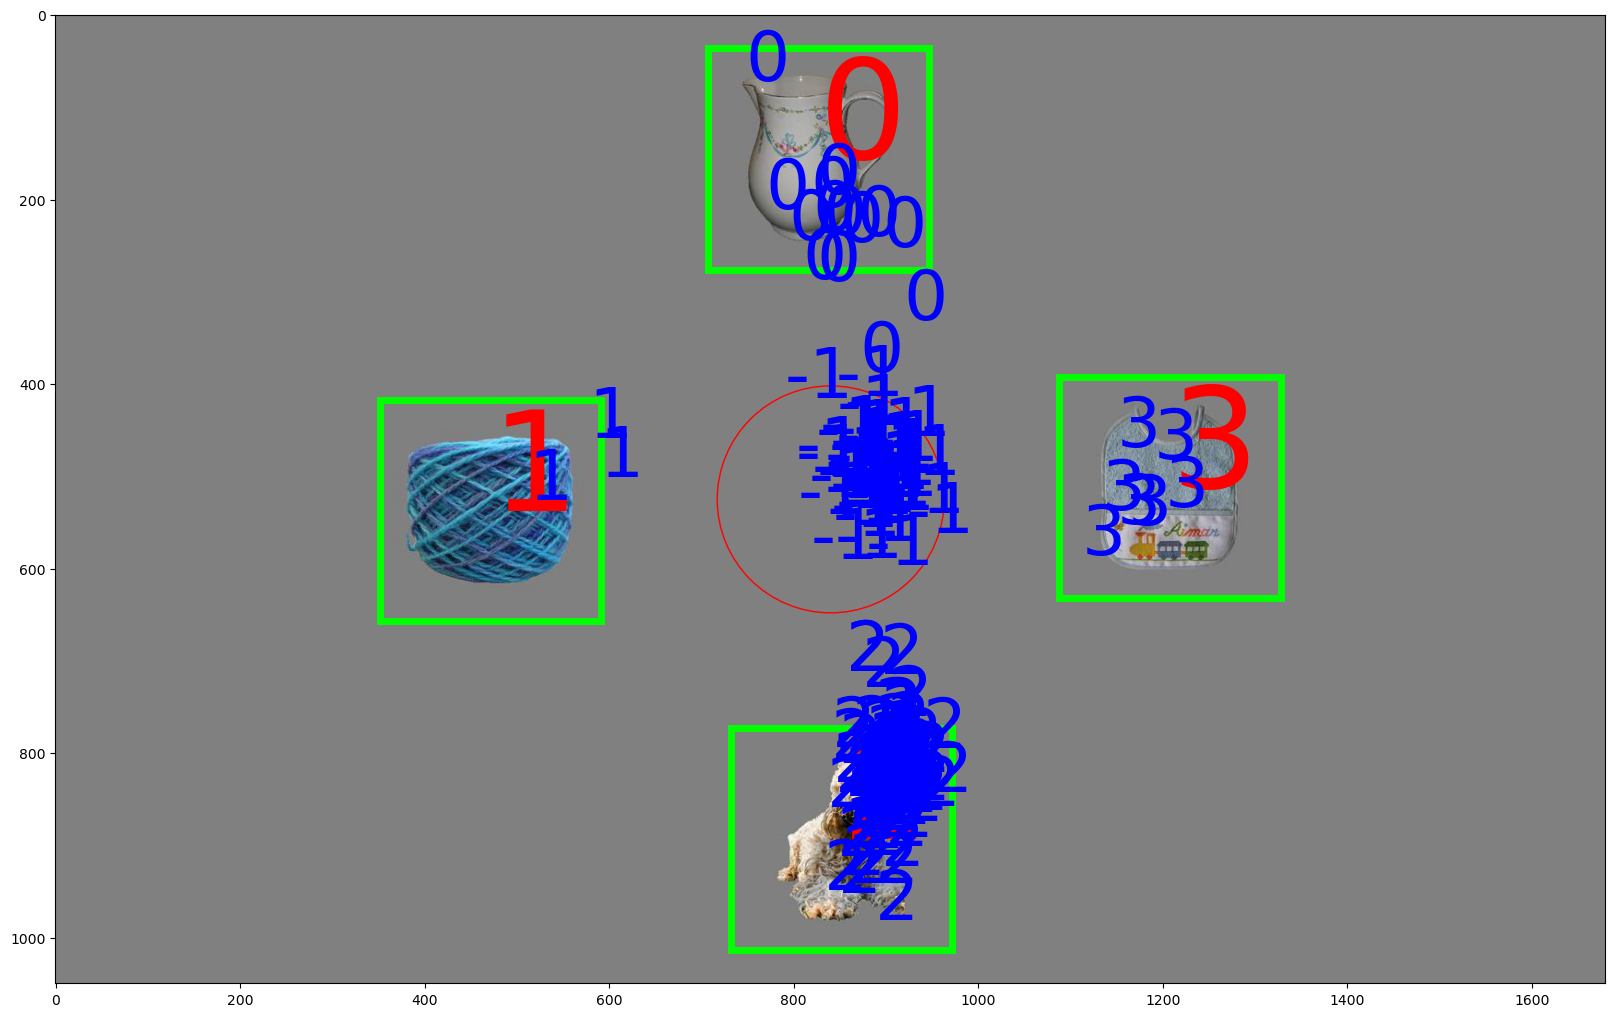

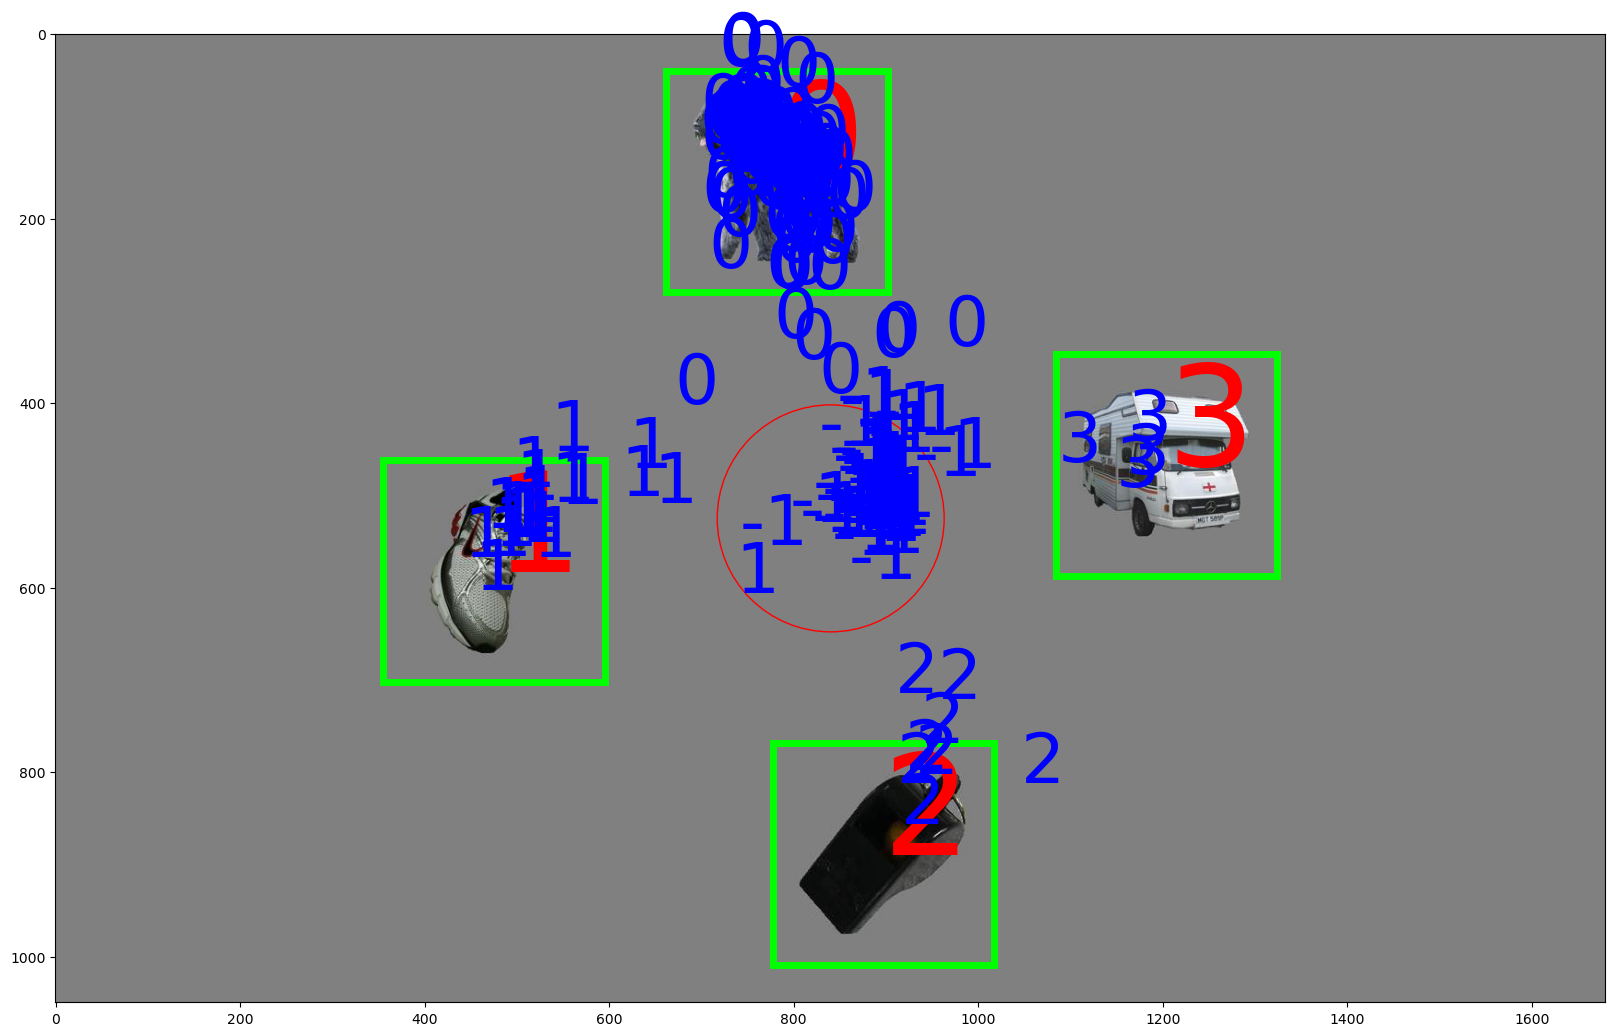

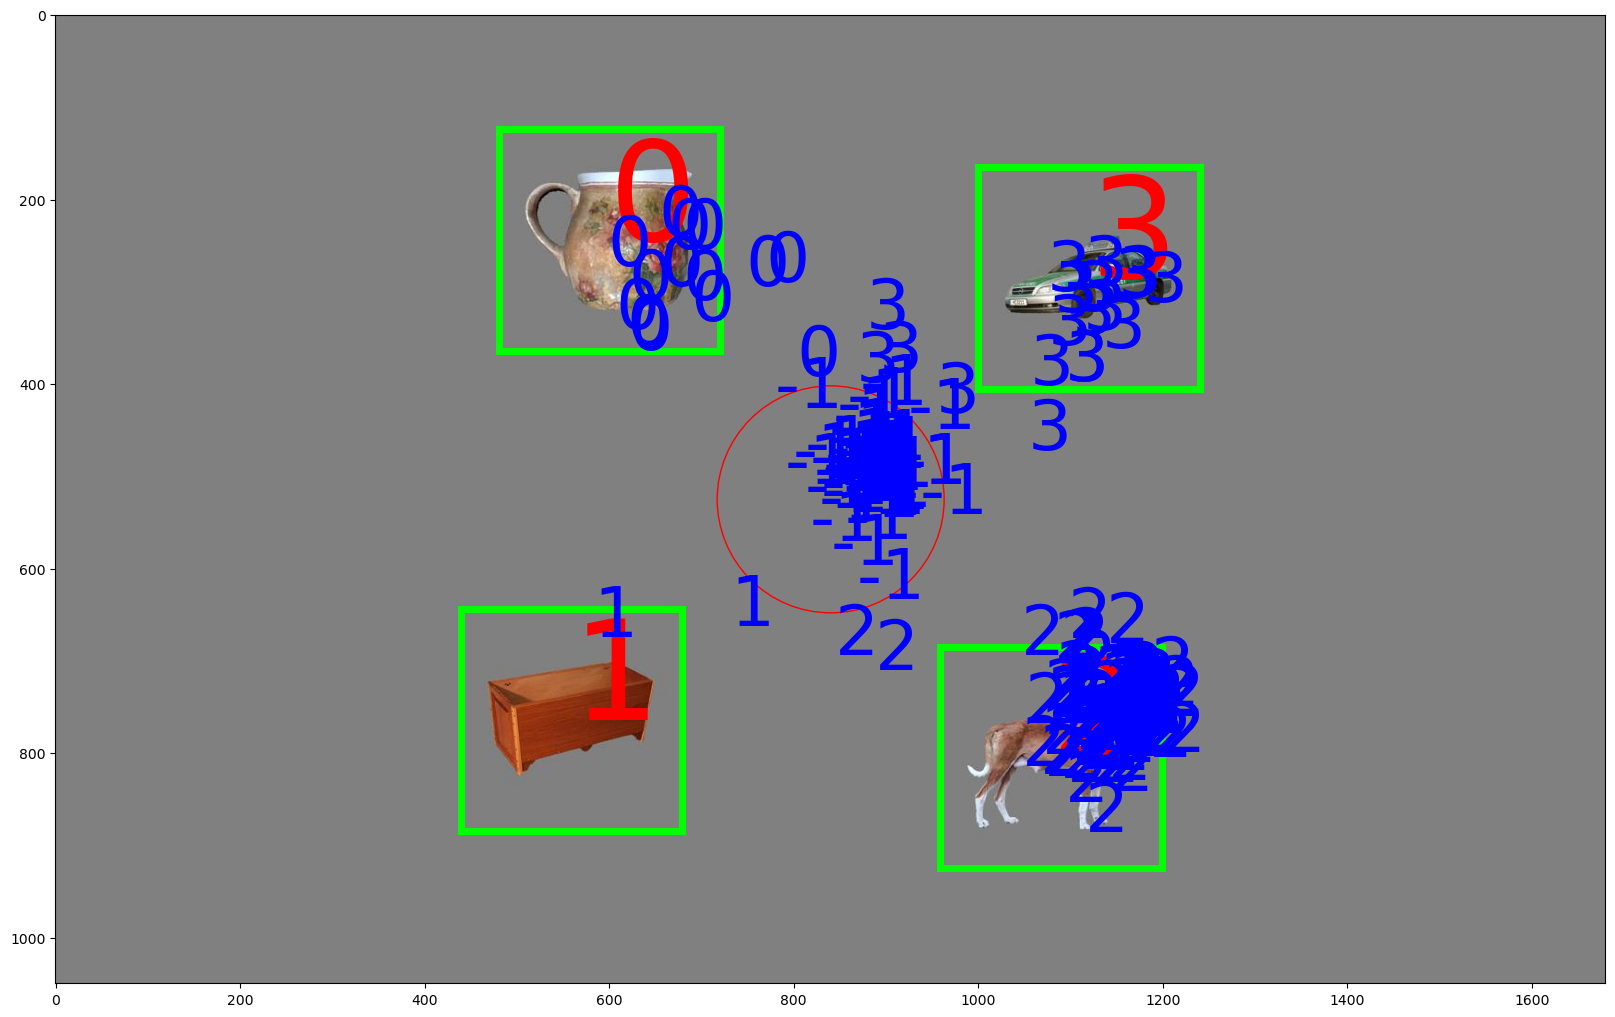

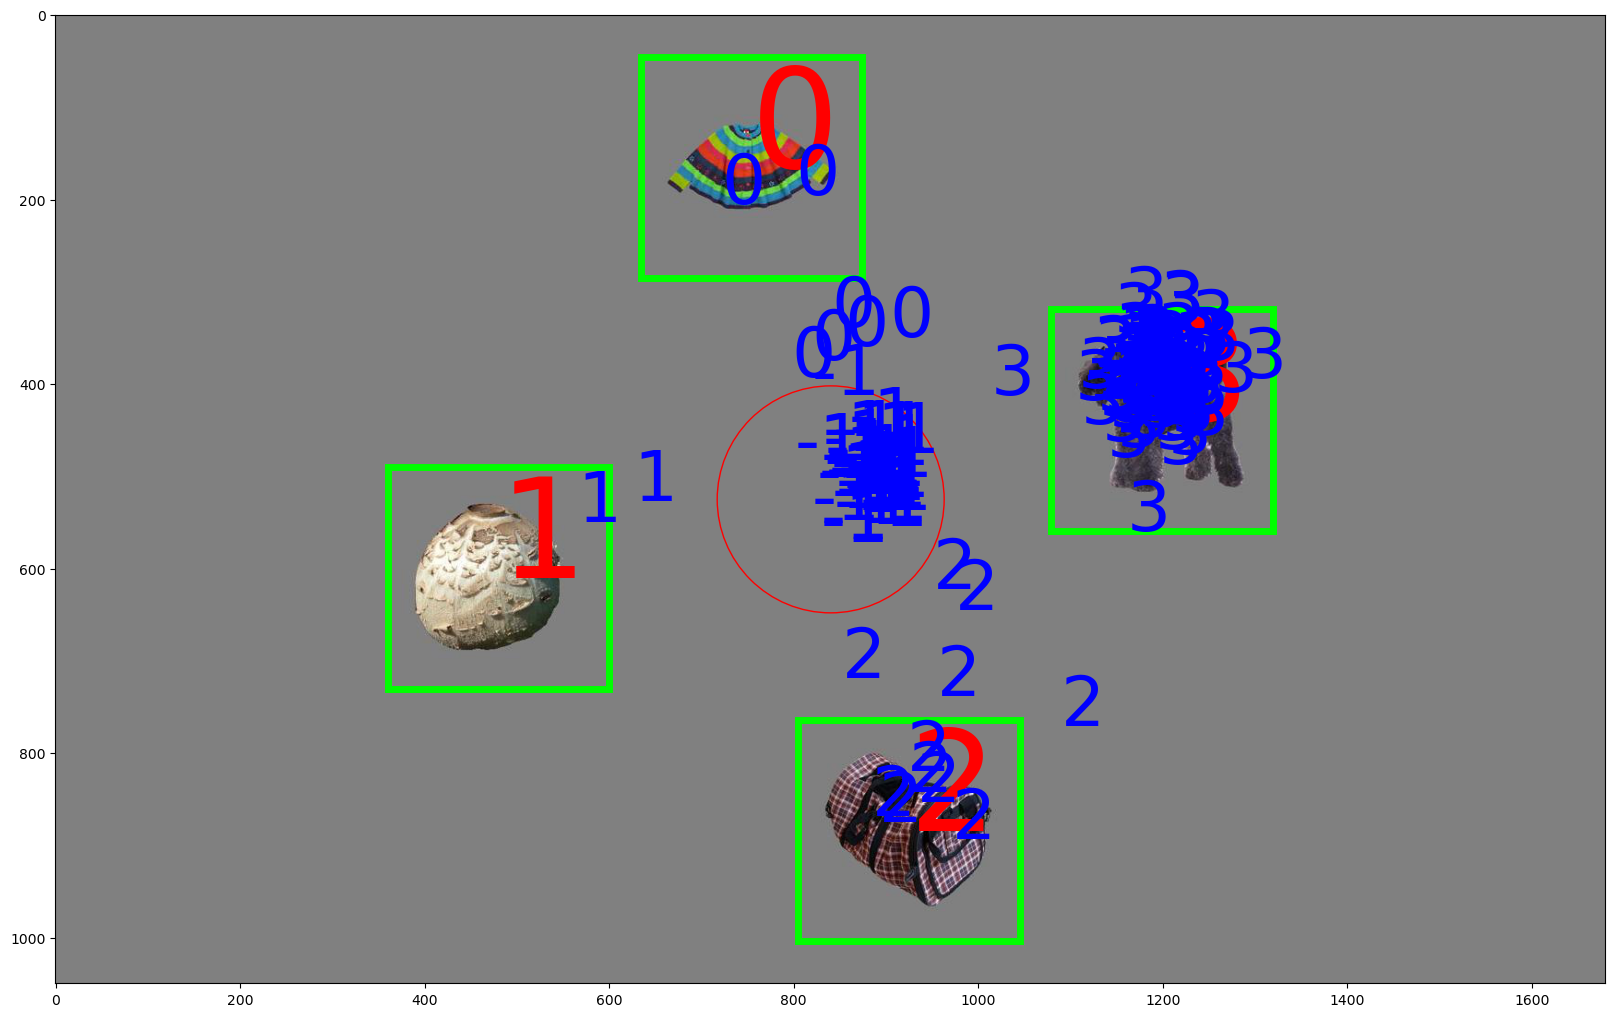

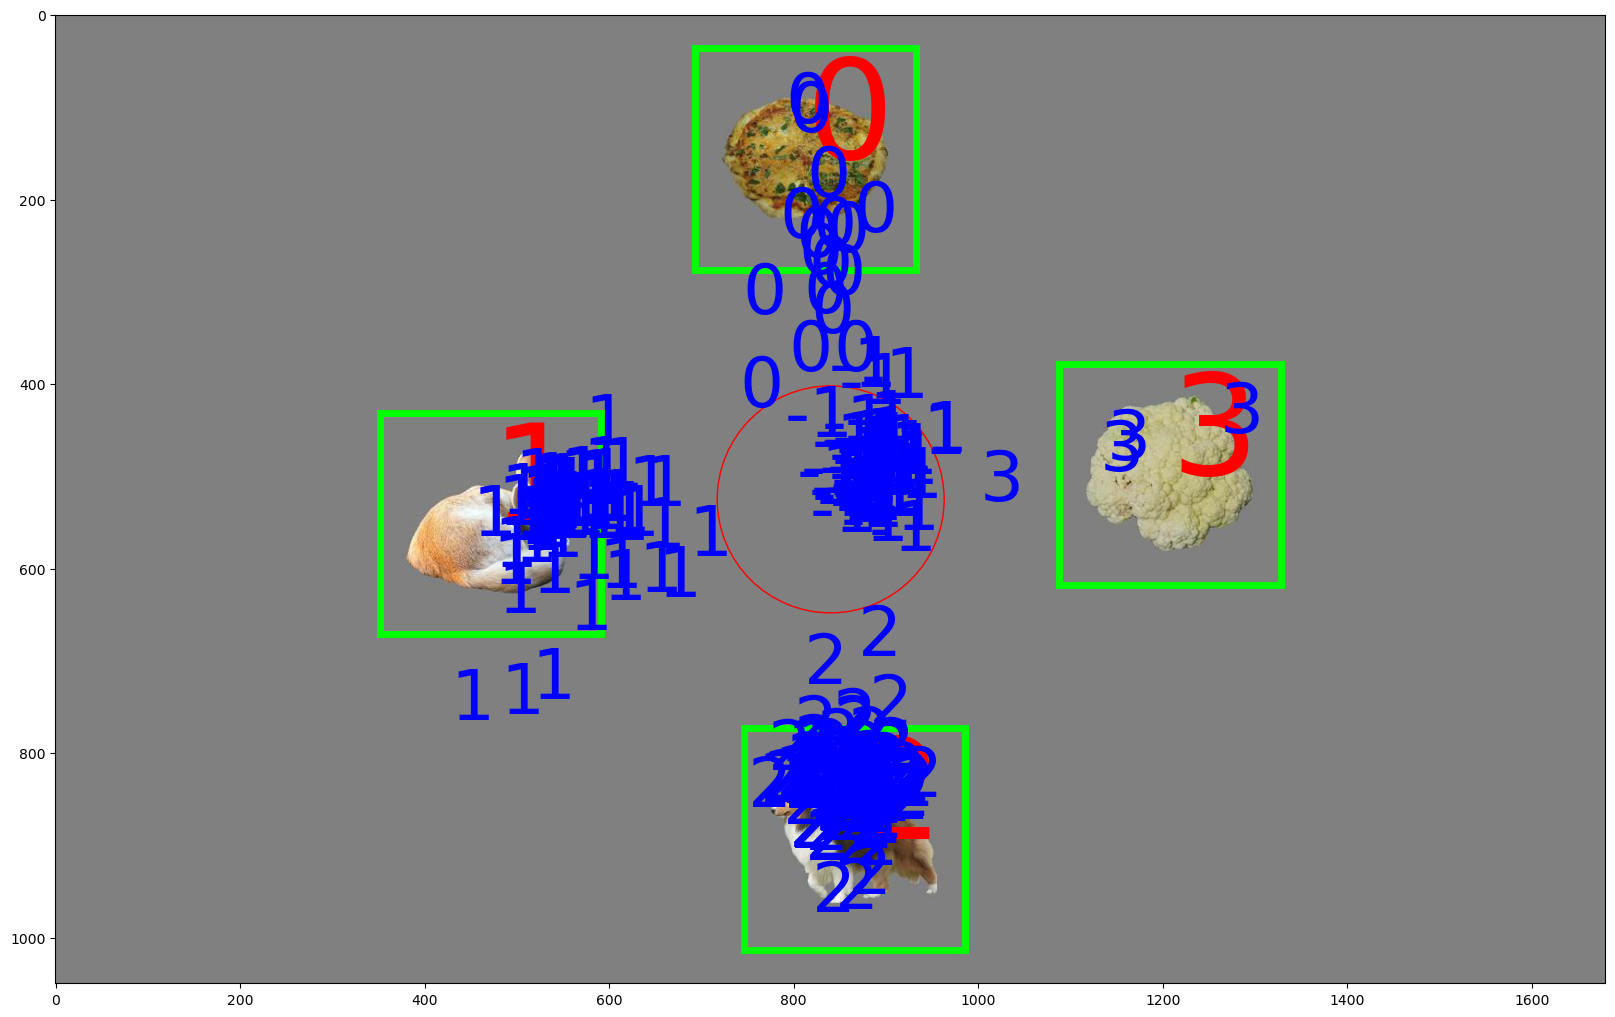

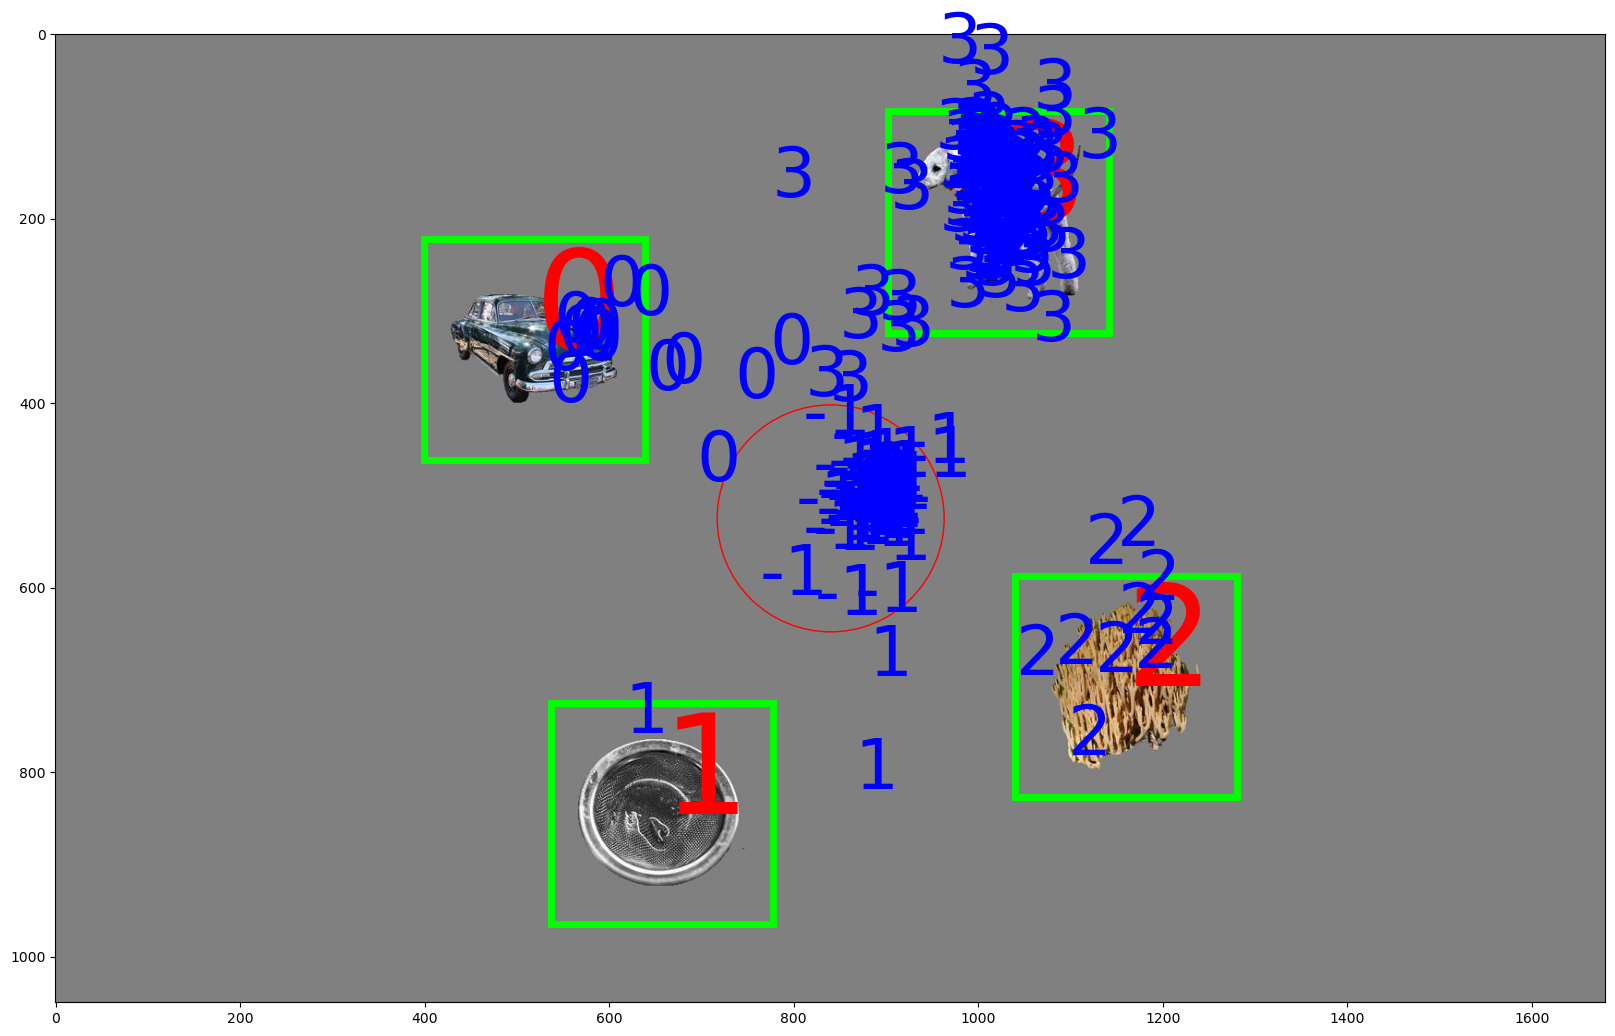

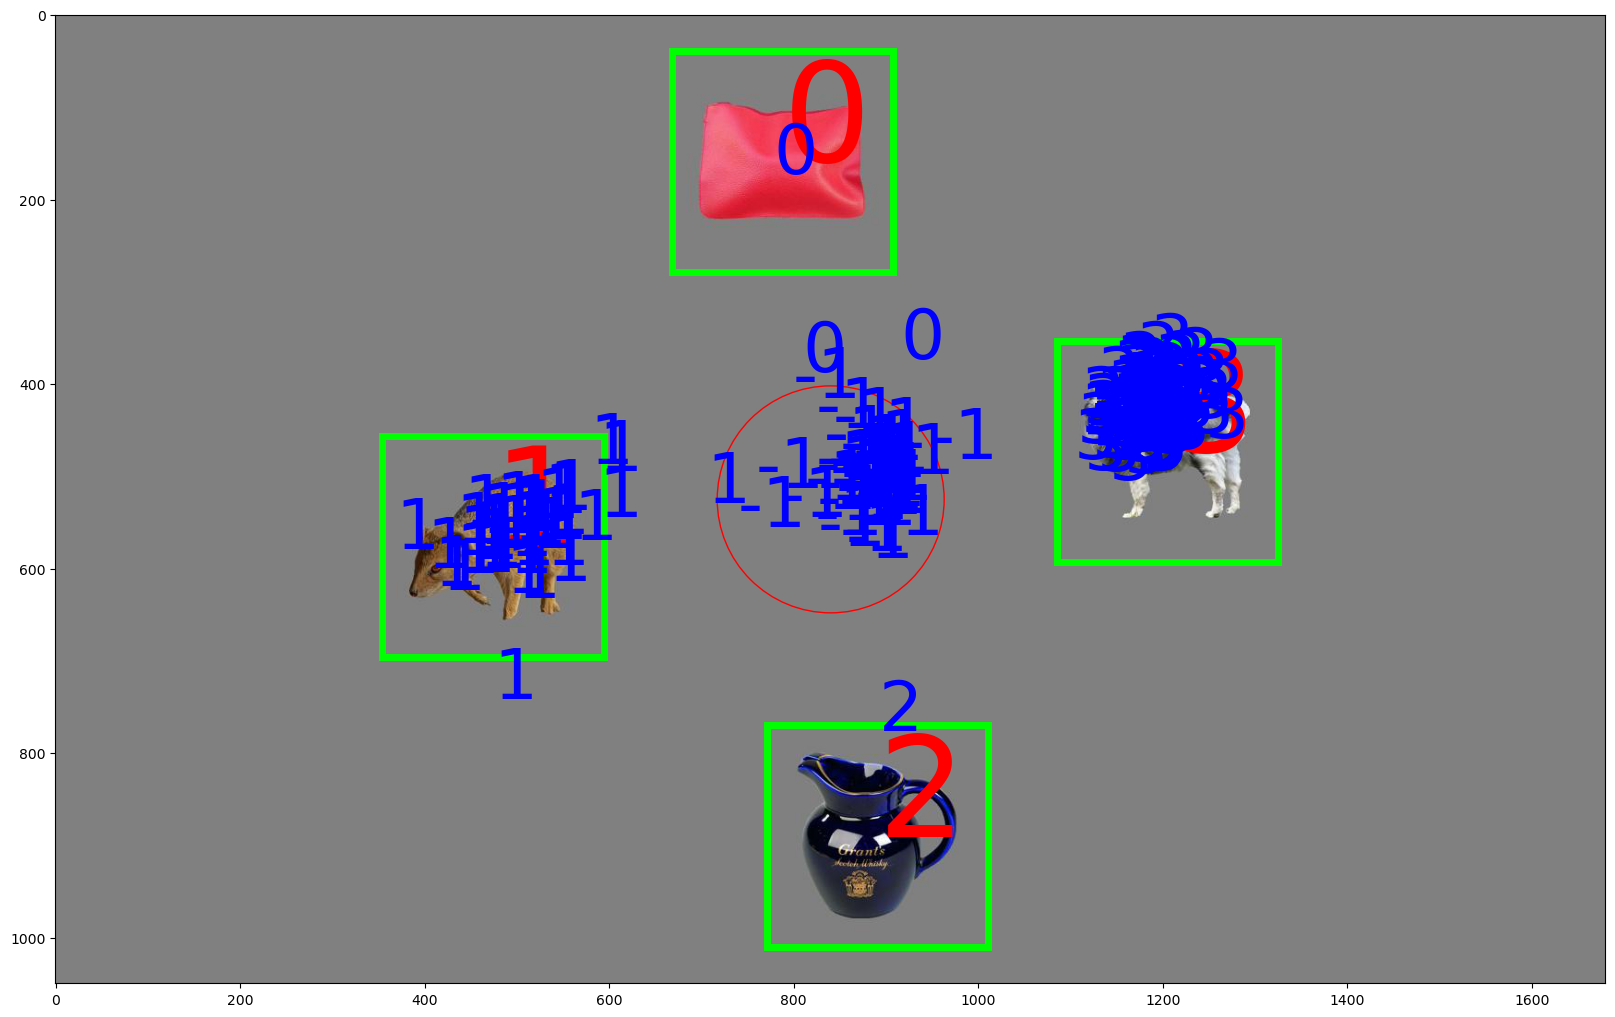

KeyboardInterrupt: 

In [6]:
DIR_STIMULI = '../exp-source/exp_datasource/screen_images/'
expimgidlist = list(np.unique([fd['IMAGE_ID'] for fd in fdictlist]))
assert len(expimgidlist) == 200#224

# add ROI labels
VISUALIZE= True
plt.rcParams["figure.figsize"]=20,20
screen_size =(1050, 1680)
x_offset = (1680-1050)/2
center_width = int(screen_size[1]/2)
center_height =int(screen_size[0]/2)

distance_from_center = 369.140625

for imgid in expimgidlist:
    fdict_under_thisid = list(filter(lambda x: x['IMAGE_ID']==imgid, fdictlist))
    imginfo = list(filter(lambda x: x['display_idx']==imgid,display_info))[0]

    if VISUALIZE:
        imgname = imginfo['display_filename']
        imgpath = DIR_STIMULI + f'{imgname}.png'
        image = Image.open(imgpath) 
    
        fig, ax = plt.subplots()
        ax.imshow(image, cmap='gray')
    #     ax.axis('off')  # Turn off axis labels and ticks

    # get bbox
    bboxes = imginfo['bboxlist'] # original bboxlist assumes square size image
    for bbox in bboxes: # add x offset to xmin and xmax
        bbox[0] = bbox[0] + x_offset
        bbox[2] = bbox[2] + x_offset

    centers = []
    for num, bi in enumerate(range(len(bboxes))): 
        xmin, ymin, xmax, ymax = bboxes[bi] # first object
        if VISUALIZE:
            ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor = 'lime', fill=False, lw=5))
            ax.text(int((xmin+xmax)/2), int((ymin+ymax)/2), str(num), fontsize=100, color='red')
        centers.append([int((xmin+xmax)/2), int((ymin+ymax)/2)])
        


    # draw circle
    radius_pixels = int(distance_from_center/3)
    if VISUALIZE:
        circle = patches.Circle((center_width, center_height), radius_pixels, fill=False, color='red')
        ax.add_patch(circle)

    
    # draw fixation point
    for fdict in fdict_under_thisid:
        
        
        roi_labels = []
        for pi, point in enumerate(zip(fdict['FIX_X'],fdict['FIX_Y'])):
            
#             point = (800, 500)
#             point = (200, 500)
            # if VISUALIZE: # show fixation index in order
            #     ax.text(point[0], point[1], pi, fontsize=50, color='blue')
#                 ax.plot(point[0], point[1], 'bo')


            # Calculate the distance between the point and the circle's center, and check if the point (x, y) is inside the circle
            distance = np.sqrt((point[0] - center_width)**2 + (point[1] - center_height)**2)
            is_inside = distance <= radius_pixels

            # Get ROI information
            if is_inside:
                roi = -1
            else:
                distances = []
                for center in centers:
                    distances.append(np.sqrt((point[0] - center[0])**2 + (point[1] - center[1])**2))
                roi = distances.index(min(distances))

            if VISUALIZE: # show roi index
                ax.text(point[0], point[1], roi, fontsize=50, color='blue')
#                 ax.plot(point[0], point[1], 'bo')
#             
            roi_labels.append(roi)
                
#         print(roi_labels)
        fdict['ROI_LABELS'] = roi_labels

    if VISUALIZE:
        plt.show()
        plt.close()
    
    


In [50]:
fdictlist[0]

{'SUBJECT_ID': 'ST024',
 'TRIAL_ID': 17,
 'CONDITION': 'TP',
 'IMAGE_ID': 1032,
 'TARGET': 'insect',
 'TARGET_PRESENT': True,
 'BUTTON_ID': 7,
 'ACC': True,
 'FIX_X': [827.8, 1099.6, 660.1],
 'FIX_Y': [503.7, 405.2, 208.0],
 'FIX_START': [0, 187, 397],
 'FIX_DURATION': [125, 132, 287],
 'AVERAGE_FIXATION_DURATION': 181.33,
 'SD_FIXATION_DURATION': 91.58,
 'AVERAGE_SACCADE_AMPLITUDE': 12.27,
 'SD_SACCADE_AMPLITUDE': 4.25,
 'REACTION_TIME': 684.0,
 'ROI_LABELS': [-1, 3, 0]}

In [17]:
# save data
import json
with open('search-gaze-roiadded.json', 'w') as f:
    json.dump(fdictlist, f)

In [ ]:
# draw polygon bbox
# def extend_line(first_xy, second_xy, screen_size, xrange, yrange):
#     # Define the two points (x1, y1) and (x2, y2)
#     x1, y1 = first_xy
#     x2, y2 = second_xy
#     # Calculate the slope of the line
#     slope = (y1 - y2) / (x1 - x2)
#     array = np.ones(screen_size)
#     # Extend the line to the edges of the array
#     for x in range(xrange[0],xrange[1]):
#         y = int(y1 + slope * (x - x1))
#         if yrange[0] <= y < yrange[1]:
#             array[y, x] = 0  # Set the pixel to 1 to represent the line
#     return array

# # first dot is between first two items
# cx1, cy1 = centers[0]
# cx2, cy2 = centers[1]
# x1 = int((cx1 + cx2)/2)
# y1 = int((cy1 + cy2)/2)
# ax.plot(x1, y1, 'bo')

# if x1 < center_width and y1 < center_height:
#     xrange =(0,center_width)
#     yrange= (0,center_height)
# elif x1 < center_width and y1 > center_height:
#     xrange =(0,center_width) 
#     yrange= (center_height, screen_size[0])
# elif x1 > center_width and y1 < center_height:
#     xrange =(center_width,  screen_size[1])
#     yrange= (0,center_height)
# else:
#     xrange =(center_width,  screen_size[1])
#     yrange= (center_height, screen_size[0])     

# array1 = extend_line((x1,y1), (center_width, center_height), screen_size, xrange, yrange)

# ax.imshow(array1, cmap='gray', alpha=0.2)


# # Get corner coordinates
# first_corner = np.where(array1[0] == 0)[0][0] #first_zero_index
# ax.plot(first_corner, 0, 'ro')
# ax.plot(center_width, center_height, 'ro')

# # second dot is between next two items
# cx1, cy1 = centers[0]
# cx2, cy2 = centers[-1]
# x1 = int((cx1 + cx2)/2)
# y1 = int((cy1 + cy2)/2)

# if x1 < center_width and y1 < center_height:

#     xrange =(0,center_width)
#     yrange= (0,center_height)
# elif x1 < center_width and y1 > center_height:
#     xrange =(0,center_width) 
#     yrange= (center_height, screen_size[0])
# elif x1 > center_width and y1 < center_height:
#     xrange =(center_width,  screen_size[1])
#     yrange= (0,center_height)
# else:
#     xrange =(center_width,  screen_size[1])
#     yrange= (center_height, screen_size[0])     

# array2 = extend_line((x1,y1), (center_width, center_height), screen_size, xrange, yrange)

# ax.imshow(array2, cmap='gray', alpha=0.2)


# # Get corner coordinates
# second_corner = np.where(array2[0] == 0)[0][0] #first_zero_index
# ax.plot(second_corner, 0, 'ro')

# ax.plot(800, 200, 'bo')

# #     is_inside = is_point_inside_triangle((x, y), a, b, (center_width, center_height))


# plt.show()
# break


In [ ]:
# there's duplicate of st030
# with open('search-gaze-roiadded.json') as f:
#     fdictlist = json.load(f)

# print(len(fdictlist))
# fdictlist2 = list(filter(lambda x: x['SUBJECT_ID'] != 'ST030 (1)', fdictlist))
# print(len(fdictlist2))

# with open('search-gaze-roiadded-2.json', 'w') as f:
#     json.dump(fdictlist2, f)